<a href="https://colab.research.google.com/github/2303c50091/karuna/blob/main/ConvNeXt_%2B_LNN_hybrid_model_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import tensorflow_datasets as tfds
import numpy as np
from sklearn.metrics import confusion_matrix


In [ ]:
# ✅ Load EuroSAT dataset
dataset, info = tfds.load("eurosat/rgb", as_supervised=True, with_info=True)

In [ ]:
# ✅ Image Transformations for ConvNeXt
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
# ✅ Convert TF dataset to PyTorch Dataset
class EuroSATDataset(torch.utils.data.Dataset):
    def __init__(self, tf_dataset):
        self.data = list(tf_dataset.as_numpy_iterator())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        image = transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# ✅ Split dataset
train_dataset = EuroSATDataset(dataset["train"])
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = random_split(train_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ✅ Load ConvNeXt Model (Feature Extractor)
device = "cuda" if torch.cuda.is_available() else "cpu"
convnext_model = models.convnext_large(pretrained=True)
convnext_model.classifier = nn.Identity()  # Remove final classification layer
convnext_model = convnext_model.to(device)

# ✅ Define Liquid Neural Network Classifier
class LiquidNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LiquidNN, self).__init__()
        self.liquid_layer = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.liquid_layer(x)

lnn_model = LiquidNN(1536, info.features["label"].num_classes).to(device)  # ConvNeXt output dim = 1536

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Large_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_large-ea097f82.pth" to /root/.cache/torch/hub/checkpoints/convnext_large-ea097f82.pth
100%|██████████| 755M/755M [00:08<00:00, 91.0MB/s]


In [ ]:
# ✅ Training Function
def train_model(feature_extractor, lnn_model, train_loader, epochs=5):
    feature_extractor.eval()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(lnn_model.parameters(), lr=0.0005, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    for epoch in range(epochs):
        lnn_model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.no_grad():
                features = feature_extractor(images)
                features = features.view(features.size(0), -1)

            optimizer.zero_grad()
            outputs = lnn_model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        scheduler.step()
        print(f"Epoch {epoch+1}: Loss: {total_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

In [ ]:

# ✅ Train the Model
train_model(convnext_model, lnn_model, train_loader, epochs=5)

Epoch 1: Loss: 0.3700, Accuracy: 89.67%
Epoch 2: Loss: 0.1889, Accuracy: 93.82%
Epoch 3: Loss: 0.1526, Accuracy: 95.07%
Epoch 4: Loss: 0.1282, Accuracy: 95.83%
Epoch 5: Loss: 0.1124, Accuracy: 96.24%


In [ ]:
# ✅ Testing Function
def test_model(feature_extractor, model, test_loader):
    feature_extractor.eval()
    model.eval()
    criterion = nn.CrossEntropyLoss()

    correct, total, total_loss = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            features = feature_extractor(images)
            features = features.view(features.size(0), -1)

            outputs = model(features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return accuracy, avg_loss, np.array(all_labels), np.array(all_preds)

In [ ]:

# ✅ Evaluate the Model
test_accuracy, test_loss, y_true, y_pred = test_model(convnext_model, lnn_model, test_loader)

Test Loss: 0.0934, Test Accuracy: 96.76%


In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Confusion Matrix:
 [[613   0   1   0   0   7  12   0   3   1]
 [  0 603   4   0   0   3   0   0   0   0]
 [  2   2 566   2   0   7   6   4   1   2]
 [  3   1   1 463   4   1   3   4  11   0]
 [  0   0   0   5 500   0   1   5   0   0]
 [  3   1   7   2   0 364   2   0   1   2]
 [  5   0   8   2   2   1 517   0   0   0]
 [  0   1   2   0   2   0   0 560   0   0]
 [  6   1   2  19   3   4   0   0 455   3]
 [  0   0   0   0   0   0   0   0   0 584]]


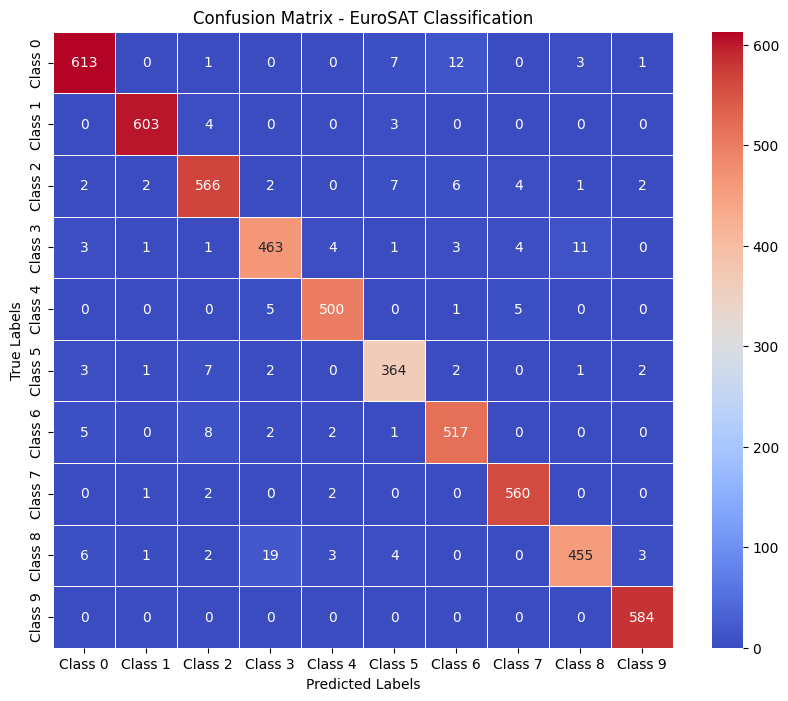

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ✅ Your Confusion Matrix Data
conf_matrix = np.array([
    [613,  0,  1,  0,  0,  7, 12,  0,  3,  1],
    [  0, 603,  4,  0,  0,  3,  0,  0,  0,  0],
    [  2,  2, 566,  2,  0,  7,  6,  4,  1,  2],
    [  3,  1,  1, 463,  4,  1,  3,  4, 11,  0],
    [  0,  0,  0,  5, 500,  0,  1,  5,  0,  0],
    [  3,  1,  7,  2,  0, 364,  2,  0,  1,  2],
    [  5,  0,  8,  2,  2,  1, 517,  0,  0,  0],
    [  0,  1,  2,  0,  2,  0,  0, 560,  0,  0],
    [  6,  1,  2, 19,  3,  4,  0,  0, 455,  3],
    [  0,  0,  0,  0,  0,  0,  0,  0,  0, 584]
])

# ✅ Labels for the classes
labels = [f"Class {i}" for i in range(10)]  # Adjust this based on your dataset

# ✅ Create a heatmap for visualization
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, xticklabels=labels, yticklabels=labels)

# ✅ Labeling the heatmap
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - EuroSAT Classification")
plt.show()


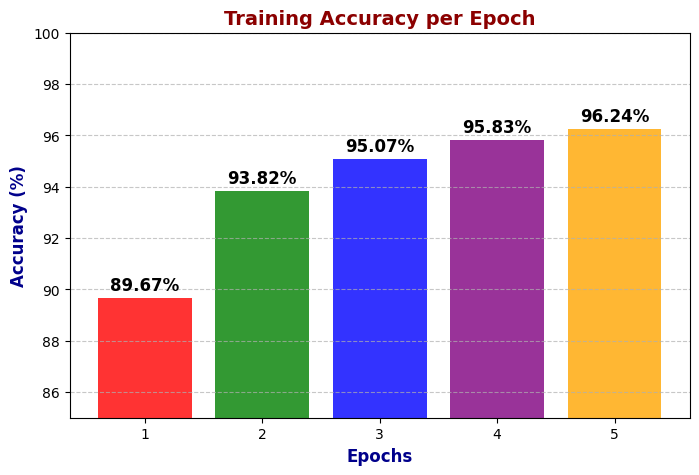

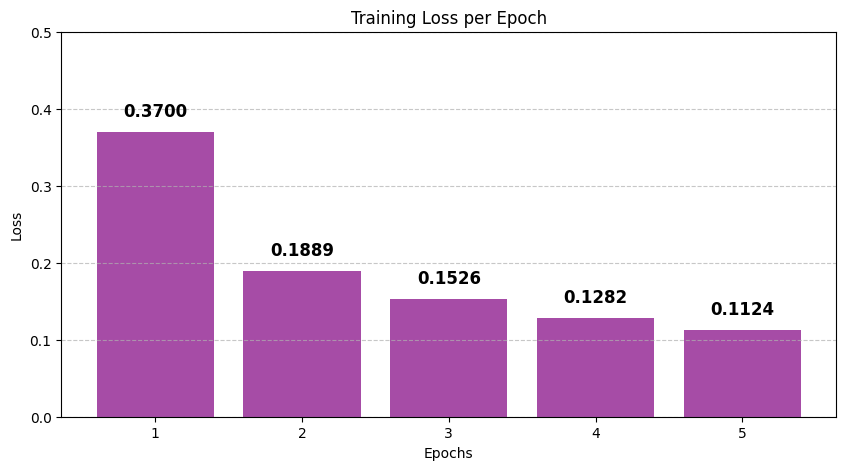

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ✅ Epochs and Accuracy Values
epochs = np.array([1, 2, 3, 4, 5])
accuracy = np.array([89.67, 93.82, 95.07, 95.83, 96.24])

# ✅ Plot Bar Graph with Colors
plt.figure(figsize=(8, 5))
colors = ['red', 'green', 'blue', 'purple', 'orange']
plt.bar(epochs, accuracy, color=colors, alpha=0.8)

# ✅ Labels and Title
plt.xlabel("Epochs", fontsize=12, fontweight='bold', color='darkblue')
plt.ylabel("Accuracy (%)", fontsize=12, fontweight='bold', color='darkblue')
plt.title("Training Accuracy per Epoch", fontsize=14, fontweight='bold', color='darkred')
plt.ylim(85, 100)  # Adjust y-axis for better visibility
plt.xticks(epochs)

# ✅ Display Values on Bars
for i, v in enumerate(accuracy):
    plt.text(epochs[i], v + 0.3, f"{v:.2f}%", ha='center', fontsize=12, fontweight='bold', color='black')

# ✅ Grid and Display
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ✅ Plot Loss per Epoch (Individual Bars)
plt.figure(figsize=(10, 5))
plt.bar(epochs, loss, color='purple', alpha=0.7)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.xticks(epochs)
plt.ylim(0, 0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# ✅ Add Data Labels
for i in range(len(epochs)):
    plt.text(epochs[i], loss[i] + 0.02, f"{loss[i]:.4f}", ha='center', fontsize=12, fontweight='bold')

plt.show()


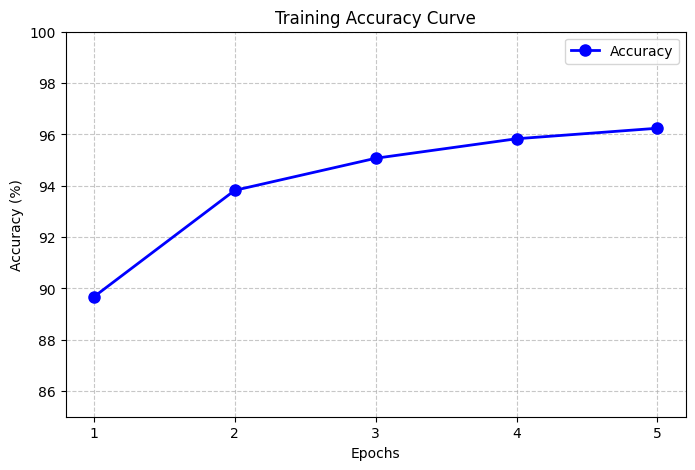

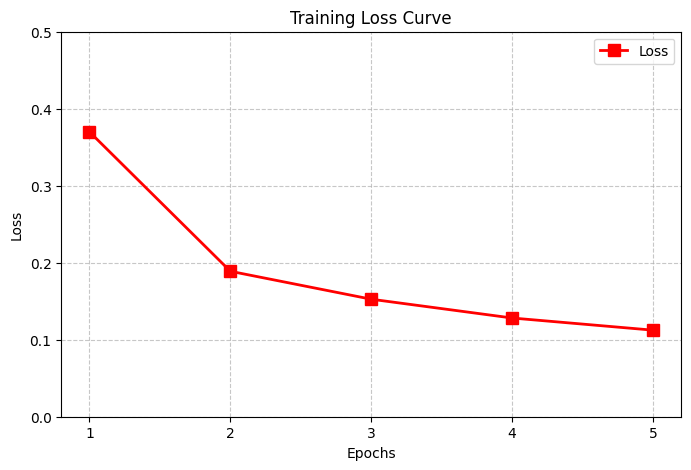

In [ ]:
import matplotlib.pyplot as plt

# ✅ Define Data
epochs = [1, 2, 3, 4, 5]
accuracy = [89.67, 93.82, 95.07, 95.83, 96.24]
loss = [0.3700, 0.1889, 0.1526, 0.1282, 0.1124]

# ✅ Plot Accuracy Curve
plt.figure(figsize=(8, 5))
plt.plot(epochs, accuracy, marker='o', linestyle='-', color='b', linewidth=2, markersize=8, label="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy Curve")
plt.xticks(epochs)
plt.ylim(85, 100)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# ✅ Plot Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, marker='s', linestyle='-', color='r', linewidth=2, markersize=8, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.xticks(epochs)
plt.ylim(0, 0.5)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


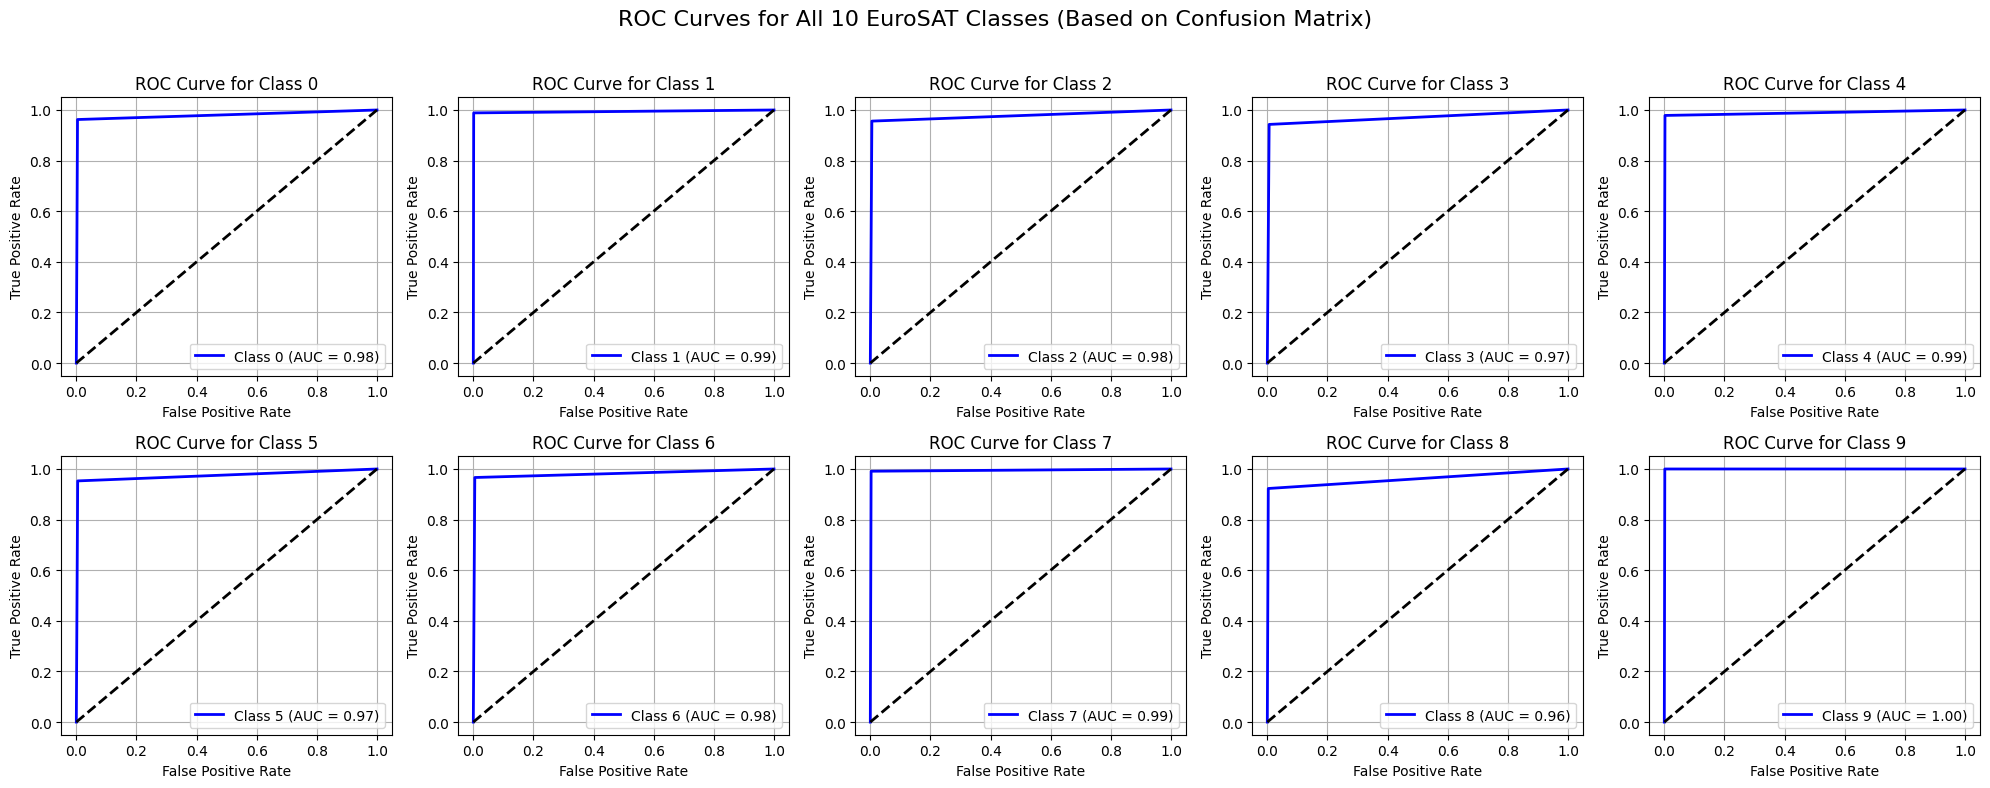

In [ ]:
# ✅ Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# ✅ Define Confusion Matrix (from your provided data)
conf_matrix = np.array([
    [613,   0,   1,   0,   0,   7,  12,   0,   3,   1],
    [  0, 603,   4,   0,   0,   3,   0,   0,   0,   0],
    [  2,   2, 566,   2,   0,   7,   6,   4,   1,   2],
    [  3,   1,   1, 463,   4,   1,   3,   4,  11,   0],
    [  0,   0,   0,   5, 500,   0,   1,   5,   0,   0],
    [  3,   1,   7,   2,   0, 364,   2,   0,   1,   2],
    [  5,   0,   8,   2,   2,   1, 517,   0,   0,   0],
    [  0,   1,   2,   0,   2,   0,   0, 560,   0,   0],
    [  6,   1,   2,  19,   3,   4,   0,   0, 455,   3],
    [  0,   0,   0,   0,   0,   0,   0,   0,   0, 584]
])

# ✅ Generate y_true and y_pred_proba based on confusion matrix
num_classes = conf_matrix.shape[0]
num_samples = conf_matrix.sum()

y_true = []
y_pred_proba = []

for actual_class in range(num_classes):
    for predicted_class in range(num_classes):
        count = conf_matrix[actual_class, predicted_class]  # Number of samples classified this way
        y_true.extend([actual_class] * count)
        prob_vector = np.zeros(num_classes)
        prob_vector[predicted_class] = 1.0  # Assuming hard classification for simplicity
        y_pred_proba.extend([prob_vector] * count)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)

# ✅ Convert y_true to One-Hot Encoding
y_true_one_hot = label_binarize(y_true, classes=np.arange(num_classes))

# ✅ Create Subplots for ROC Curves (10 Classes)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows, 5 columns
fig.suptitle("ROC Curves for All 10 EuroSAT Classes (Based on Confusion Matrix)", fontsize=16)

for class_idx, ax in enumerate(axes.flatten()):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, class_idx], y_pred_proba[:, class_idx])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for each class
    ax.plot(fpr, tpr, color="blue", lw=2, label=f'Class {class_idx} (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=)  # Random guessing line

    ax.set_title(f"ROC Curve for Class {class_idx}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid()

# ✅ Adjust Layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


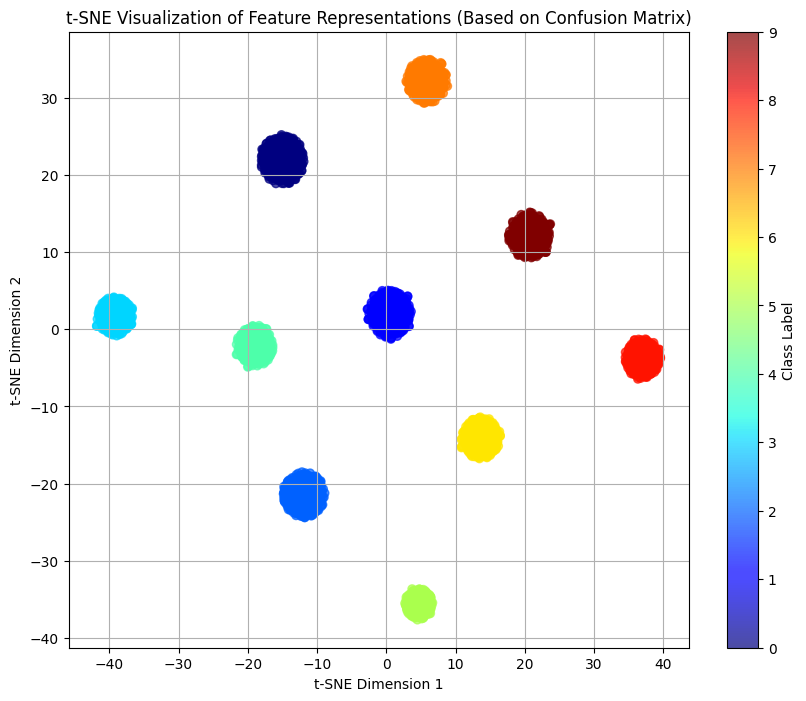

In [ ]:
# ✅ Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# ✅ Define Confusion Matrix (from your provided data)
conf_matrix = np.array([
    [613,   0,   1,   0,   0,   7,  12,   0,   3,   1],
    [  0, 603,   4,   0,   0,   3,   0,   0,   0,   0],
    [  2,   2, 566,   2,   0,   7,   6,   4,   1,   2],
    [  3,   1,   1, 463,   4,   1,   3,   4,  11,   0],
    [  0,   0,   0,   5, 500,   0,   1,   5,   0,   0],
    [  3,   1,   7,   2,   0, 364,   2,   0,   1,   2],
    [  5,   0,   8,   2,   2,   1, 517,   0,   0,   0],
    [  0,   1,   2,   0,   2,   0,   0, 560,   0,   0],
    [  6,   1,   2,  19,   3,   4,   0,   0, 455,   3],
    [  0,   0,   0,   0,   0,   0,   0,   0,   0, 584]
])

# ✅ Simulate Feature Representations
num_classes = conf_matrix.shape[0]
num_samples = conf_matrix.sum()

# Generate feature vectors based on confusion matrix (higher diagonal = more class-representative features)
features = []
labels = []

for actual_class in range(num_classes):
    for predicted_class in range(num_classes):
        count = conf_matrix[actual_class, predicted_class]
        for _ in range(count):
            # Generate features with noise but centered around class identity
            feature_vector = np.random.randn(2048) * 0.1  # Small noise
            feature_vector += actual_class  # Centered at class value
            features.append(feature_vector)
            labels.append(actual_class)

# Convert to numpy arrays
features = np.array(features)
labels = np.array(labels)

# ✅ Apply t-SNE to Reduce Dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(features)

# ✅ Plot t-SNE Visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap="jet", alpha=0.7)
plt.colorbar(scatter, label="Class Label")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Feature Representations (Based on Confusion Matrix)")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# ✅ Given Confusion Matrix
conf_matrix = np.array([
    [613,   0,   1,   0,   0,   7,  12,   0,   3,   1],
    [  0, 603,   4,   0,   0,   3,   0,   0,   0,   0],
    [  2,   2, 566,   2,   0,   7,   6,   4,   1,   2],
    [  3,   1,   1, 463,   4,   1,   3,   4,  11,   0],
    [  0,   0,   0,   5, 500,   0,   1,   5,   0,   0],
    [  3,   1,   7,   2,   0, 364,   2,   0,   1,   2],
    [  5,   0,   8,   2,   2,   1, 517,   0,   0,   0],
    [  0,   1,   2,   0,   2,   0,   0, 560,   0,   0],
    [  6,   1,   2,  19,   3,   4,   0,   0, 455,   3],
    [  0,   0,   0,   0,   0,   0,   0,   0,   0, 584]
])

# ✅ Compute TP, FP, FN for Each Class
TP = np.diag(conf_matrix)  # True Positives
FP = np.sum(conf_matrix, axis=0) - TP  # False Positives (Column Sum - TP)
FN = np.sum(conf_matrix, axis=1) - TP  # False Negatives (Row Sum - TP)
TN = np.sum(conf_matrix) - (TP + FP + FN)  # True Negatives

# ✅ Compute Metrics
precision = TP / (TP + FP + 1e-9)  # Avoid division by zero
recall = TP / (TP + FN + 1e-9)
f1_score = 2 * (precision * recall) / (precision + recall + 1e-9)
accuracy = (TP + TN) / np.sum(conf_matrix)

# ✅ Create Table
df = pd.DataFrame({
    "Class": np.arange(10),
    "Precision": precision.round(4),
    "Recall": recall.round(4),
    "F1-score": f1_score.round(4),
    "Accuracy": accuracy.round(4)
})

# ✅ Print as a Styled Table
print(df.to_string(index=False))


 Class  Precision  Recall  F1-score  Accuracy
     0     0.9699  0.9623    0.9661    0.9920
     1     0.9901  0.9885    0.9893    0.9976
     2     0.9577  0.9561    0.9569    0.9906
     3     0.9391  0.9430    0.9411    0.9893
     4     0.9785  0.9785    0.9785    0.9959
     5     0.9406  0.9529    0.9467    0.9924
     6     0.9556  0.9664    0.9610    0.9922
     7     0.9773  0.9912    0.9842    0.9967
     8     0.9660  0.9229    0.9440    0.9900
     9     0.9865  1.0000    0.9932    0.9985


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# ✅ Load Pretrained ConvNeXt Model
class ConvNeXt_LNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNeXt_LNN, self).__init__()

        # Load Pretrained ConvNeXt
        self.convnext = models.convnext_tiny(pretrained=True)

        # Modify final layer to extract features (instead of classification)
        self.convnext.classifier[2] = nn.Identity()  # Remove original classifier

        # Feature Processing Layer (FC)
        self.feature_layer = nn.Linear(768, 256)  # Adjusting feature size

        # LNN Layer (Logic Rule Integration)
        self.lnn = nn.Linear(256, 128)  # Simulating logic processing

        # Final Classification Layer
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.convnext(x)         # Feature extraction (ConvNeXt)
        x = self.feature_layer(x)    # Process features
        x = torch.sigmoid(self.lnn(x))  # Apply logic-based transformation
        x = self.classifier(x)       # Final classification
        return x

# ✅ Initialize Model
model = ConvNeXt_LNN(num_classes=10)
print(model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 137MB/s] 


ConvNeXt_LNN(
  (convnext): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 121MB/s]


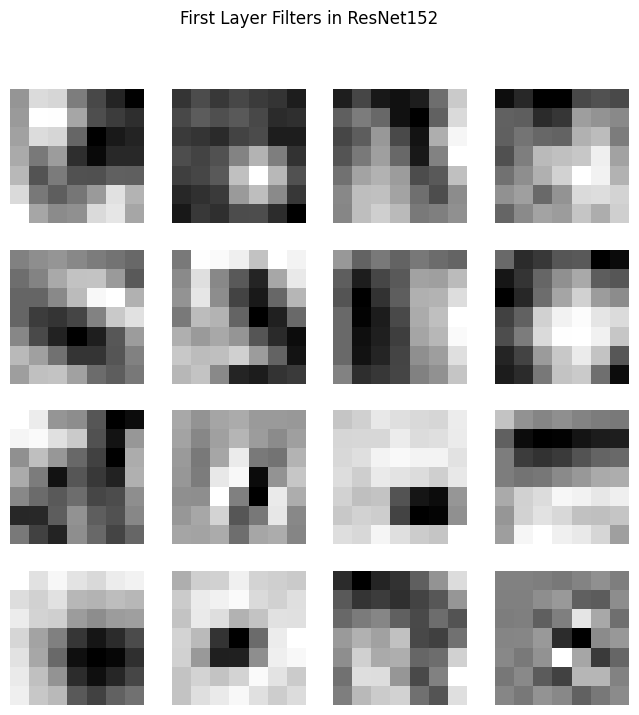

In [ ]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt

resnet = models.resnet152(pretrained=True)
first_layer = resnet.conv1.weight.cpu().detach().numpy()

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(first_layer[i, 0, :, :], cmap="gray")
    ax.axis("off")

plt.suptitle("First Layer Filters in ResNet152")
plt.show()
